# 注意力机制
在“编码器—解码器（seq2seq）”⼀节⾥，解码器在各个时间步依赖相同的背景变量（context vector）来获取输⼊序列信息。当编码器为循环神经⽹络时，背景变量来⾃它最终时间步的隐藏状态。将源序列输入信息以循环单位状态编码，然后将其传递给解码器以生成目标序列。然而这种结构存在着问题，尤其是RNN机制实际中存在长程梯度消失的问题，对于较长的句子，我们很难寄希望于将输入的序列转化为定长的向量而保存所有的有效信息，所以随着所需翻译句子的长度的增加，这种结构的效果会显著下降。

与此同时，解码的目标词语可能只与原输入的部分词语有关，而并不是与所有的输入有关。例如，当把“Hello world”翻译成“Bonjour le monde”时，“Hello”映射成“Bonjour”，“world”映射成“monde”。在seq2seq模型中，解码器只能隐式地从编码器的最终状态中选择相应的信息。然而，注意力机制可以将这种选择过程显式地建模。

![Image Name](https://cdn.kesci.com/upload/image/q5km4dwgf9.PNG?imageView2/0/w/960/h/960)

## 注意力机制框架

Attention 是一种通用的带权池化方法，输入由两部分构成：询问（query）和键值对（key-value pairs）。$𝐤_𝑖∈ℝ^{𝑑_𝑘}, 𝐯_𝑖∈ℝ^{𝑑_𝑣}$. Query  $𝐪∈ℝ^{𝑑_𝑞}$ , attention layer得到输出与value的维度一致 $𝐨∈ℝ^{𝑑_𝑣}$. 对于一个query来说，attention layer 会与每一个key计算注意力分数并进行权重的归一化，输出的向量$o$则是value的加权求和，而每个key计算的权重与value一一对应。

为了计算输出，我们首先假设有一个函数$\alpha$ 用于计算query和key的相似性，然后可以计算所有的 attention scores $a_1, \ldots, a_n$ by


$$
a_i = \alpha(\mathbf q, \mathbf k_i).
$$


我们使用 softmax函数 获得注意力权重：


$$
b_1, \ldots, b_n = \textrm{softmax}(a_1, \ldots, a_n).
$$


最终的输出就是value的加权求和：


$$
\mathbf o = \sum_{i=1}^n b_i \mathbf v_i.
$$


![Image Name](https://cdn.kesci.com/upload/image/q5km4ooyu2.PNG?imageView2/0/w/960/h/960)

不同的attetion layer的区别在于score函数的选择，在本节的其余部分，我们将讨论两个常用的注意层 Dot-product Attention 和 Multilayer Perceptron Attention；随后我们将实现一个引入attention的seq2seq模型并在英法翻译语料上进行训练与测试。
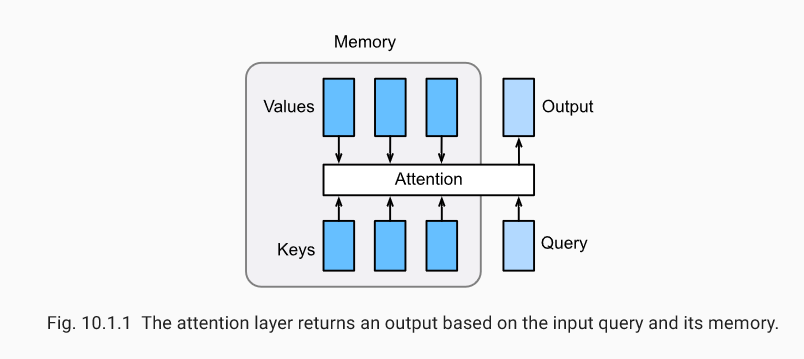
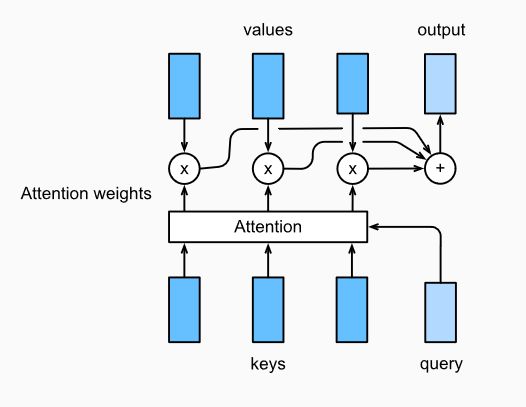

In [4]:
import math
import torch 
import torch.nn as nn

In [5]:
import os
def file_name_walk(file_dir):
    for root, dirs, files in os.walk(file_dir):
#         print("root", root)  # 当前目录路径
         print("dirs", dirs)  # 当前路径下所有子目录
         print("files", files)  # 当前路径下所有非目录子文件

file_name_walk("/home/kesci/input/fraeng6506")

dirs []
files ['_about.txt', 'fra.txt']


### Softmax屏蔽
在深入研究实现之前，我们首先介绍softmax操作符的一个屏蔽操作。

In [6]:
def SequenceMask(X, X_len,value=-1e6):
    maxlen = X.size(1)
    #print(X.size(),torch.arange((maxlen),dtype=torch.float)[None, :],'\n',X_len[:, None] )
    mask = torch.arange((maxlen),dtype=torch.float)[None, :] >= X_len[:, None]   
    #print(mask)
    X[mask]=value
    return X

In [7]:
def masked_softmax(X, valid_length):
    # X: 3-D tensor, valid_length: 1-D or 2-D tensor
    softmax = nn.Softmax(dim=-1)
    if valid_length is None:
        return softmax(X)
    else:
        shape = X.shape
        if valid_length.dim() == 1:
            try:
                valid_length = torch.FloatTensor(valid_length.numpy().repeat(shape[1], axis=0))#[2,2,3,3]
            except:
                valid_length = torch.FloatTensor(valid_length.cpu().numpy().repeat(shape[1], axis=0))#[2,2,3,3]
        else:
            valid_length = valid_length.reshape((-1,))
        # fill masked elements with a large negative, whose exp is 0
        X = SequenceMask(X.reshape((-1, shape[-1])), valid_length)
 
        return softmax(X).reshape(shape)

In [8]:
masked_softmax(torch.rand((2,2,4),dtype=torch.float), torch.FloatTensor([2,3]))

tensor([[[0.5423, 0.4577, 0.0000, 0.0000],
         [0.5290, 0.4710, 0.0000, 0.0000]],

        [[0.2969, 0.2966, 0.4065, 0.0000],
         [0.3607, 0.2203, 0.4190, 0.0000]]])

**超出2维矩阵的乘法** 

$X$ 和 $Y$ 是维度分别为$(b,n,m)$ 和$(b, m, k)$的张量，进行 $b$ 次二维矩阵乘法后得到 $Z$, 维度为 $(b, n, k)$。


$$
 Z[i,:,:] = dot(X[i,:,:], Y[i,:,:])\qquad for\ i= 1,…,n\ .
$$


In [9]:
torch.bmm(torch.ones((2,1,3), dtype = torch.float), torch.ones((2,3,2), dtype = torch.float))

tensor([[[3., 3.]],

        [[3., 3.]]])

# 点积注意力
The dot product 假设query和keys有相同的维度, 即 $\forall i, 𝐪,𝐤_𝑖 ∈ ℝ_𝑑 $. 通过计算query和key转置的乘积来计算attention score,通常还会除去 $\sqrt{d}$ 减少计算出来的score对维度𝑑的依赖性，如下


$$
𝛼(𝐪,𝐤)=⟨𝐪,𝐤⟩/ \sqrt{d} 
$$

假设 $ 𝐐∈ℝ^{𝑚×𝑑}$ 有 $m$ 个query，$𝐊∈ℝ^{𝑛×𝑑}$ 有 $n$ 个keys. 我们可以通过矩阵运算的方式计算所有 $mn$ 个score：


$$
𝛼(𝐐,𝐊)=𝐐𝐊^𝑇/\sqrt{d}
$$
 
现在让我们实现这个层，它支持一批查询和键值对。此外，它支持作为正则化随机删除一些注意力权重.

In [10]:
# Save to the d2l package.
class DotProductAttention(nn.Module): 
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # query: (batch_size, #queries, d)
    # key: (batch_size, #kv_pairs, d)
    # value: (batch_size, #kv_pairs, dim_v)
    # valid_length: either (batch_size, ) or (batch_size, xx)
    def forward(self, query, key, value, valid_length=None):
        d = query.shape[-1]
        # set transpose_b=True to swap the last two dimensions of key
        
        scores = torch.bmm(query, key.transpose(1,2)) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        print("attention_weight\n",attention_weights)
        return torch.bmm(attention_weights, value)

### 测试
现在我们创建了两个批，每个批有一个query和10个key-values对。我们通过valid_length指定，对于第一批，我们只关注前2个键-值对，而对于第二批，我们将检查前6个键-值对。因此，尽管这两个批处理具有相同的查询和键值对，但我们获得的输出是不同的。

In [11]:
atten = DotProductAttention(dropout=0)

keys = torch.ones((2,10,2),dtype=torch.float)
values = torch.arange((40), dtype=torch.float).view(1,10,4).repeat(2,1,1)
atten(torch.ones((2,1,2),dtype=torch.float), keys, values, torch.FloatTensor([2, 6]))

attention_weight
 tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000]]])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

# 多层感知机注意力
在多层感知器中，我们首先将 query and keys 投影到  $ℝ^ℎ$ .为了更具体，我们将可以学习的参数做如下映射 
$𝐖_𝑘∈ℝ^{ℎ×𝑑_𝑘}$ ,  $𝐖_𝑞∈ℝ^{ℎ×𝑑_𝑞}$ , and  $𝐯∈ℝ^h$ . 将score函数定义
$$
𝛼(𝐤,𝐪)=𝐯^𝑇tanh(𝐖_𝑘𝐤+𝐖_𝑞𝐪)
$$
. 
然后将key 和 value 在特征的维度上合并（concatenate），然后送至 a single hidden layer perceptron 这层中 hidden layer 为  ℎ  and 输出的size为 1 .隐层激活函数为tanh，无偏置.

In [12]:
# Save to the d2l package.
class MLPAttention(nn.Module):  
    def __init__(self, units,ipt_dim,dropout, **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        # Use flatten=True to keep query's and key's 3-D shapes.
        self.W_k = nn.Linear(ipt_dim, units, bias=False)
        self.W_q = nn.Linear(ipt_dim, units, bias=False)
        self.v = nn.Linear(units, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, valid_length):
        query, key = self.W_k(query), self.W_q(key)
        #print("size",query.size(),key.size())
        # expand query to (batch_size, #querys, 1, units), and key to
        # (batch_size, 1, #kv_pairs, units). Then plus them with broadcast.
        features = query.unsqueeze(2) + key.unsqueeze(1)
        #print("features:",features.size())  #--------------开启
        scores = self.v(features).squeeze(-1) 
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        return torch.bmm(attention_weights, value)

### 测试
尽管MLPAttention包含一个额外的MLP模型，但如果给定相同的输入和相同的键，我们将获得与DotProductAttention相同的输出

In [13]:
atten = MLPAttention(ipt_dim=2,units = 8, dropout=0)
atten(torch.ones((2,1,2), dtype = torch.float), keys, values, torch.FloatTensor([2, 6]))

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward>)

# 总结

- 注意力层显式地选择相关的信息。
- 注意层的内存由键-值对组成，因此它的输出接近于键类似于查询的值。

# 引入注意力机制的Seq2seq模型

本节中将注意机制添加到sequence to sequence 模型中，以显式地使用权重聚合states。下图展示encoding 和decoding的模型结构，在时间步为t的时候。此刻attention layer保存着encodering看到的所有信息——即encoding的每一步输出。在decoding阶段，解码器的$t$时刻的隐藏状态被当作query，encoder的每个时间步的hidden states作为key和value进行attention聚合. Attetion model的输出当作成上下文信息context vector，并与解码器输入$D_t$拼接起来一起送到解码器：

![Image Name](https://cdn.kesci.com/upload/image/q5km7o8z93.PNG?imageView2/0/w/800/h/800)

$$
Fig1具有注意机制的seq-to-seq模型解码的第二步
$$


下图展示了seq2seq机制的所以层的关系，下面展示了encoder和decoder的layer结构

![Image Name](https://cdn.kesci.com/upload/image/q5km8dihlr.PNG?imageView2/0/w/800/h/800)

$$
Fig2具有注意机制的seq-to-seq模型中层结构
$$

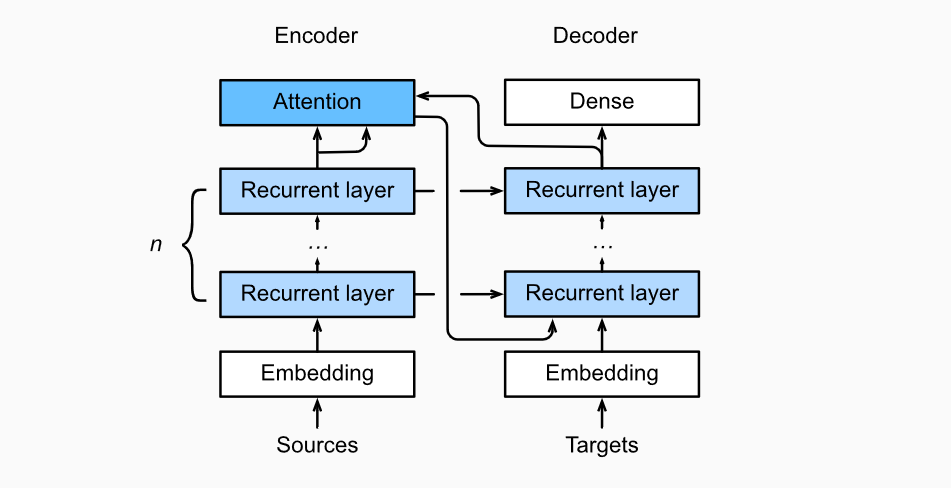
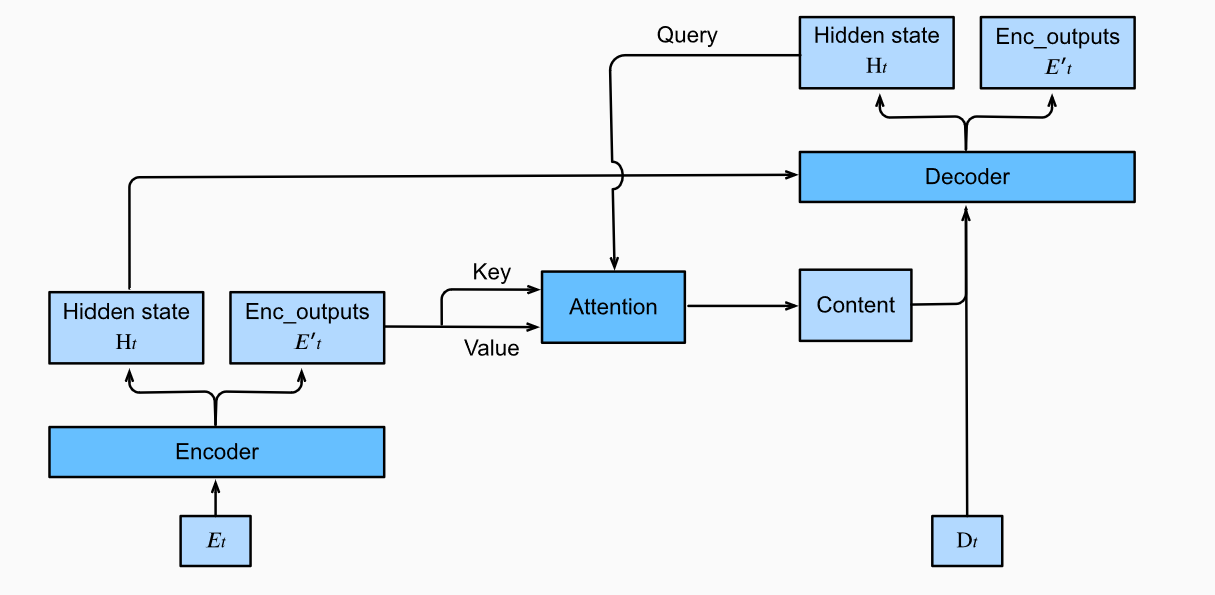

In [14]:
import sys
sys.path.append('/home/kesci/input/d2len9900')
import d2l

## 解码器
   由于带有注意机制的seq2seq的编码器与之前章节中的Seq2SeqEncoder相同，所以在此处我们只关注解码器。我们添加了一个MLP注意层(MLPAttention)，它的隐藏大小与解码器中的LSTM层相同。然后我们通过从编码器传递三个参数来初始化解码器的状态:
   
- the encoder outputs of all timesteps：encoder输出的各个状态，被用于attetion layer的memory部分，有相同的key和values


- the hidden state of the encoder’s final timestep：编码器最后一个时间步的隐藏状态，被用于初始化decoder 的hidden state


- the encoder valid length: 编码器的有效长度，借此，注意层不会考虑编码器输出中的填充标记（Paddings）


   在解码的每个时间步，我们使用解码器的最后一个RNN层的输出作为注意层的query。然后，将注意力模型的输出与输入嵌入向量连接起来，输入到RNN层。虽然RNN层隐藏状态也包含来自解码器的历史信息，但是attention model的输出显式地选择了enc_valid_len以内的编码器输出，这样attention机制就会尽可能排除其他不相关的信息。

In [15]:
class Seq2SeqAttentionDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention_cell = MLPAttention(num_hiddens,num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size+ num_hiddens,num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs, enc_valid_len, *args):
        outputs, hidden_state = enc_outputs
#         print("first:",outputs.size(),hidden_state[0].size(),hidden_state[1].size())
        # Transpose outputs to (batch_size, seq_len, hidden_size)
        return (outputs.permute(1,0,-1), hidden_state, enc_valid_len)
        #outputs.swapaxes(0, 1)
        
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_len = state
        #("X.size",X.size())
        X = self.embedding(X).transpose(0,1)
#         print("Xembeding.size2",X.size())
        outputs = []
        for l, x in enumerate(X):
#             print(f"\n{l}-th token")
#             print("x.first.size()",x.size())
            # query shape: (batch_size, 1, hidden_size)
            # select hidden state of the last rnn layer as query
            query = hidden_state[0][-1].unsqueeze(1) # np.expand_dims(hidden_state[0][-1], axis=1)
            # context has same shape as query
#             print("query enc_outputs, enc_outputs:\n",query.size(), enc_outputs.size(), enc_outputs.size())
            context = self.attention_cell(query, enc_outputs, enc_outputs, enc_valid_len)
            # Concatenate on the feature dimension
#             print("context.size:",context.size())
            x = torch.cat((context, x.unsqueeze(1)), dim=-1)
            # Reshape x to (1, batch_size, embed_size+hidden_size)
#             print("rnn",x.size(), len(hidden_state))
            out, hidden_state = self.rnn(x.transpose(0,1), hidden_state)
            outputs.append(out)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.transpose(0, 1), [enc_outputs, hidden_state,
                                        enc_valid_len]

现在我们可以用注意力模型来测试seq2seq。为了与第9.7节中的模型保持一致，我们对vocab_size、embed_size、num_hiddens和num_layers使用相同的超参数。结果，我们得到了相同的解码器输出形状，但是状态结构改变了。

In [16]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8,
                            num_hiddens=16, num_layers=2)
# encoder.initialize()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8,
                                  num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7),dtype=torch.long)
print("batch size=4\nseq_length=7\nhidden dim=16\nnum_layers=2\n")
print('encoder output size:', encoder(X)[0].size())
print('encoder hidden size:', encoder(X)[1][0].size())
print('encoder memory size:', encoder(X)[1][1].size())
state = decoder.init_state(encoder(X), None)
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

batch size=4
seq_length=7
hidden dim=16
num_layers=2

encoder output size: torch.Size([7, 4, 16])
encoder hidden size: torch.Size([2, 4, 16])
encoder memory size: torch.Size([2, 4, 16])


(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([2, 4, 16]))

# 训练

  与第9.7.4节相似，通过应用相同的训练超参数和相同的训练损失来尝试一个简单的娱乐模型。从结果中我们可以看出，由于训练数据集中的序列相对较短，额外的注意层并没有带来显著的改进。由于编码器和解码器的注意层的计算开销，该模型比没有注意的seq2seq模型慢得多。

In [21]:
import zipfile
import torch
import requests
from io import BytesIO
from torch.utils import data
import sys
import collections

class Vocab(object): # This class is saved in d2l.
  def __init__(self, tokens, min_freq=0, use_special_tokens=False):
    # sort by frequency and token
    counter = collections.Counter(tokens)
    token_freqs = sorted(counter.items(), key=lambda x: x[0])
    token_freqs.sort(key=lambda x: x[1], reverse=True)
    if use_special_tokens:
      # padding, begin of sentence, end of sentence, unknown
      self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
      tokens = ['', '', '', '']
    else:
      self.unk = 0
      tokens = ['']
    tokens += [token for token, freq in token_freqs if freq >= min_freq]
    self.idx_to_token = []
    self.token_to_idx = dict()
    for token in tokens:
      self.idx_to_token.append(token)
      self.token_to_idx[token] = len(self.idx_to_token) - 1
      
  def __len__(self):
    return len(self.idx_to_token)
  
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    else:
      return [self.__getitem__(token) for token in tokens]
    
  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    else:
      return [self.idx_to_token[index] for index in indices]

def load_data_nmt(batch_size, max_len, num_examples=1000):
    """Download an NMT dataset, return its vocabulary and data iterator."""
    # Download and preprocess
    def preprocess_raw(text):
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        out = ''
        for i, char in enumerate(text.lower()):
            if char in (',', '!', '.') and text[i-1] != ' ':
                out += ' '
            out += char
        return out 


    with open('/home/kesci/input/fraeng6506/fra.txt', 'r') as f:
      raw_text = f.read()


    text = preprocess_raw(raw_text)

    # Tokenize
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if i >= num_examples:
            break
        parts = line.split('\t')
        if len(parts) >= 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))

    # Build vocab
    def build_vocab(tokens):
        tokens = [token for line in tokens for token in line]
        return Vocab(tokens, min_freq=3, use_special_tokens=True)
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)

    # Convert to index arrays
    def pad(line, max_len, padding_token):
        if len(line) > max_len:
            return line[:max_len]
        return line + [padding_token] * (max_len - len(line))

    def build_array(lines, vocab, max_len, is_source):
        lines = [vocab[line] for line in lines]
        if not is_source:
            lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
        array = torch.tensor([pad(line, max_len, vocab.pad) for line in lines])
        valid_len = (array != vocab.pad).sum(1)
        return array, valid_len

    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, max_len, False)
    train_data = data.TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    train_iter = data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [18]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, ctx = 0.005, 500, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)

## 训练和预测

In [19]:
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, ctx)

epoch   50,loss 0.104, time 54.7 sec
epoch  100,loss 0.046, time 54.8 sec
epoch  150,loss 0.031, time 54.7 sec
epoch  200,loss 0.027, time 54.3 sec
epoch  250,loss 0.025, time 54.3 sec
epoch  300,loss 0.024, time 54.4 sec
epoch  350,loss 0.024, time 54.4 sec
epoch  400,loss 0.024, time 54.5 sec
epoch  450,loss 0.023, time 54.4 sec
epoch  500,loss 0.023, time 54.7 sec


In [20]:
for sentence in ['Go .', 'Good Night !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, ctx))

Go . => va !
Good Night ! =>   !
I'm OK . => ça va .
I won ! => j'ai gagné !
